<a href="https://colab.research.google.com/github/kappandrew2/DataPreProcessing/blob/main/MarketResearch_v003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Purpose

Utilize historical value and time attributes to predict the next day's gain or loss value

!Dataset Notes: The dataset for this data solution must come from the following web sit and contain a large historical sample of data. For example:

Begin Date = 12/01/2007 (Be mindful that the last 35 periods (in this case, days) will get chopped off of the bottom of the dataset during data preprocessing)

End Date = Today's current value (to be run an hour before market close)

Ticker = SPY

Train Set = all data except last 60 periods (rows)

Prediction Set = all data from -90 periods (days) to current

https://www.wsj.com/market-data/quotes/index/SPX/historical-prices


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from datetime import date, datetime, timedelta
from pandas._libs.tslibs.timestamps import Timestamp
from scipy.sparse import csr_matrix


#Connect to drive and import data set

Using google drive

Importing historical prices for ticker "SPY"

In [10]:
#Create CSV from data export
#https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesSPY.csv')

dataset2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesSH.csv')

print(dataset1)

Mounted at /content/drive
          Date    Open      High     Low     Close     Volume
0     08/05/21  440.22  441.8500  439.88  441.7600   38573200
1     08/04/21  439.78  441.1243  438.73  438.9800   46732207
2     08/03/21  438.44  441.2800  436.10  441.1500   58053898
3     08/02/21  440.34  440.9300  437.21  437.5900   58783301
4     07/30/21  437.91  440.0600  437.77  438.5100   68951203
...        ...     ...       ...     ...       ...        ...
1403  01/08/16  195.19  195.8500  191.58  191.9230  209817203
1404  01/07/16  195.33  197.4400  193.59  194.0500  213436094
1405  01/06/16  198.34  200.0600  197.60  198.8200  152112609
1406  01/05/16  201.40  201.9000  200.05  201.3600  110845797
1407  01/04/16  200.49  201.0300  198.59  201.0192  222353500

[1408 rows x 6 columns]


#Modifiy dataset Content and Headers

Remove contents not required for this exercise

Renaming columns to remove leading white space

Narrowing the dataset can be done via drop or select, both options are available (comment out the one not in use)

In [83]:
#Reduce dataframe columns
dataset1.rename({' Close': 'Close'}, axis=1, inplace = True)
dataset1 = dataset1[['Close', 'Date']]
#Reduce Dataframe columns
dataset2.rename({' Close': 'Close'}, axis=1, inplace = True)
dataset2 = dataset2[['Close', 'Date']]

#Set data types
dataset1['Date'] = pd.to_datetime(dataset1['Date'])
#Set data types
dataset2['Date'] = pd.to_datetime(dataset2['Date'])

#Create date attributes
dataset1['DOW'] = dataset1['Date'].dt.dayofweek
dataset1['Month'] = dataset1['Date'].dt.month
dataset1['Quarter'] = dataset1['Date'].dt.quarter
#Create date attributes
dataset2['DOW'] = dataset2['Date'].dt.dayofweek
dataset2['Month'] = dataset2['Date'].dt.month
dataset2['Quarter'] = dataset2['Date'].dt.quarter

#Date to sparse matrix
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
#Encode Time Variables
dow1 = ohe.fit_transform(dataset1.DOW.values.reshape(-1,1)).toarray()
DOW1 = pd.DataFrame(dow1, columns = ['Tu', 'We', 'Th', 'Fr'])
month1 = ohe.fit_transform(dataset1.Month.values.reshape(-1,1)).toarray()
MONTH1 = pd.DataFrame(month1, columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
q1 = ohe.fit_transform(dataset1.Quarter.values.reshape(-1,1)).toarray()
Q1 = pd.DataFrame(q1, columns = ['Q2', 'Q3', 'Q4'])
dataset1 = pd.concat([dataset1, DOW1, MONTH1, Q1], axis=1)
#Encode Time Variables
dow2 = ohe.fit_transform(dataset2.DOW.values.reshape(-1,1)).toarray()
DOW2 = pd.DataFrame(dow2, columns = ['Tu', 'We', 'Th', 'Fr'])
month2 = ohe.fit_transform(dataset2.Month.values.reshape(-1,1)).toarray()
MONTH2 = pd.DataFrame(month2, columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
q2 = ohe.fit_transform(dataset2.Quarter.values.reshape(-1,1)).toarray()
Q2 = pd.DataFrame(q2, columns = ['Q2', 'Q3', 'Q4'])
dataset2 = pd.concat([dataset2, DOW2, MONTH2, Q2], axis=1)

#Gain_loss_interval
dataset1['gain_loss_0'] = dataset1['Close'].diff(-1)
dataset1['gain_loss_1'] = dataset1['Close'].diff(-2)
dataset1['gain_loss_2'] = dataset1['Close'].diff(-3)
#Gain_loss_interval
dataset2['gain_loss_0'] = dataset2['Close'].diff(-1)
dataset2['gain_loss_1'] = dataset2['Close'].diff(-2)
dataset2['gain_loss_2'] = dataset2['Close'].diff(-3)

#Gain_loss_history
dataset1['prior_day_1'] = dataset1['gain_loss_0']
dataset1['prior_day_1'] = dataset1['prior_day_1'].shift(periods=-1, fill_value=0)
dataset1['prior_day_2'] = dataset1['gain_loss_0']
dataset1['prior_day_2'] = dataset1['prior_day_2'].shift(periods=-2, fill_value=0)
#Gain_loss_history
dataset2['prior_day_1'] = dataset2['gain_loss_0']
dataset2['prior_day_1'] = dataset2['prior_day_1'].shift(periods=-1, fill_value=0)
dataset2['prior_day_2'] = dataset2['gain_loss_0']
dataset2['prior_day_2'] = dataset2['prior_day_2'].shift(periods=-2, fill_value=0)

#Rolling means
rolling_prior_day1 = dataset1['gain_loss_0']
rolling_prior_day_5_1 = rolling_prior_day1[::-1].rolling(5).mean()[::-1]
rolling_prior_day_10_1 = rolling_prior_day1[::-1].rolling(10).mean()[::-1]
rolling_prior_day_5_1.rename('rolling_prior_day_5', inplace = True)
rolling_prior_day_10_1.rename('rolling_prior_day_10', inplace = True)
dataset = pd.concat([dataset1, rolling_prior_day_10_1, rolling_prior_day_10_1], axis = 1)
#Rolling means
rolling_prior_day2 = dataset2['gain_loss_0']
rolling_prior_day_5_2 = rolling_prior_day2[::-1].rolling(5).mean()[::-1]
rolling_prior_day_10_2 = rolling_prior_day2[::-1].rolling(10).mean()[::-1]
rolling_prior_day_5_2.rename('rolling_prior_day_5', inplace = True)
rolling_prior_day_10_2.rename('rolling_prior_day_10', inplace = True)
dataset = pd.concat([dataset2, rolling_prior_day_10_2, rolling_prior_day_10_2], axis = 1)

#Remove NaN rows
dataset1.dropna(inplace = True)
#Remove NaN rows
dataset2.dropna(inplace = True)

#add dependant variable (requires shifted down one row)
y1 = pd.DataFrame(dataset1['gain_loss_0']).reset_index(drop = True)
y1.loc[-1] = [0]
y1.index = y1.index + 1
y1 = y1.sort_index()
y1.drop(y1.tail(1).index, inplace = True)
y1.rename(columns={'gain_loss_0': 'y'}, inplace=True)
y_df1 = pd.DataFrame(y1, columns=['y'])
dataset_final1 = pd.concat([dataset1, y_df1], axis=1)
#add dependant variable (requires shifted down one row)
y2 = pd.DataFrame(dataset2['gain_loss_0']).reset_index(drop = True)
y2.loc[-1] = [0]
y2.index = y2.index + 1
y2 = y2.sort_index()
y2.drop(y2.tail(1).index, inplace = True)
y2.rename(columns={'gain_loss_0': 'y'}, inplace=True)
y_df2 = pd.DataFrame(y2, columns=['y'])
dataset_final2 = pd.concat([dataset2, y_df2], axis=1)

#drop NaN on final datase
dataset_final1.dropna(inplace = True)
#drop NaN on final datase
dataset_final2.dropna(inplace = True)

In [88]:
print(dataset_final1)

         Close       Date  DOW  ...  prior_day_1  prior_day_2       y
0     441.7600 2021-08-05    3  ...      -2.1700       3.5600  0.0000
1     438.9800 2021-08-04    2  ...       3.5600      -0.9200  2.7800
2     441.1500 2021-08-03    1  ...      -0.9200      -2.1400 -2.1700
3     437.5900 2021-08-02    0  ...      -2.1400       1.8200  3.5600
4     438.5100 2021-07-30    4  ...       1.8200      -0.1800 -0.9200
...        ...        ...  ...  ...          ...          ...     ...
1367  199.0000 2016-03-02    2  ...       4.5500      -1.5292  0.7750
1368  198.1100 2016-03-01    1  ...      -1.5292      -0.4508  0.8900
1369  193.5600 2016-02-29    0  ...      -0.4508       2.3400  4.5500
1370  195.0892 2016-02-26    4  ...       2.3400       0.8800 -1.5292
1371  195.5400 2016-02-25    3  ...       0.8800      -2.4600 -0.4508

[1372 rows x 29 columns]


In [79]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
#Encode Time Variables
dow1 = ohe.fit_transform(dataset1.DOW.values.reshape(-1,1)).toarray()
DOW1 = pd.DataFrame(dow1, columns = ['Tu', 'We', 'Th', 'Fr'])
month1 = ohe.fit_transform(dataset1.Month.values.reshape(-1,1)).toarray()
MONTH1 = pd.DataFrame(month1, columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
q1 = ohe.fit_transform(dataset1.Quarter.values.reshape(-1,1)).toarray()
Q1 = pd.DataFrame(q1, columns = ['Q2', 'Q3', 'Q4'])


#ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
#DOW_matrix1 = ct.fit_transform(dataset_final1['DOW'].values)

In [77]:
list(dataset.columns)

pandas.core.frame.DataFrame

#Create a correlation matrix

Evaluate the effectiveness of each attribute in relation to y and yb

In [41]:
corr_mx = dataset_final2.corr()

print(corr_mx)

                Close       DOW     Month  ...  prior_day_1  prior_day_2         y
Close        1.000000  0.005948 -0.002592  ...    -0.004028    -0.001291 -0.031498
DOW          0.005948  1.000000 -0.012790  ...     0.011404    -0.030397  0.035855
Month       -0.002592 -0.012790  1.000000  ...     0.018764     0.019157  0.011121
Quarter     -0.012090 -0.015046  0.969448  ...     0.009550     0.007940  0.003289
gain_loss_0  0.011465  0.016036  0.014259  ...    -0.246938     0.144737 -0.251513
gain_loss_1  0.006049  0.022356  0.026911  ...     0.614488    -0.079228 -0.089834
gain_loss_2  0.004025 -0.002013  0.034319  ...     0.336084     0.595209 -0.088736
prior_day_1 -0.004028  0.011404  0.018764  ...     1.000000    -0.241639  0.140930
prior_day_2 -0.001291 -0.030397  0.019157  ...    -0.241639     1.000000 -0.024763
y           -0.031498  0.035855  0.011121  ...     0.140930    -0.024763  1.000000

[10 rows x 10 columns]


In [ ]:
# Export to view expected results...

corr_mx.to_csv('/content/drive/MyDrive/Colab Notebooks/correlation_matrix.csv')

#Create dataset splitting variable (Train and Pred)

Date variables based on today date are required to prevent "hardcoding" dates into the model

The date_var variable will represent the most current date in the dataset. This allows the solution to be run for any timeframe.

The following code can replace the current date_var logic in the case the current method causes issues. Note, this method requires adjustment when back testing 

date_var = pd.to_datetime(date.today()) 

use train/pred_minus_days to tune the model for longer or shorter periods of time. Allow for a 30 day overlap where pred will have 30 days

In [ ]:
train_minus_days = 90
pred_minus_days = 90

date_var = dataset_final['Date'].max()
train_begin_date = dataset_final['Date'].min()
train_end_date = (date_var - pd.to_timedelta(train_minus_days, unit='d'))
pred_begin_date = (date_var - pd.to_timedelta(pred_minus_days, unit='d'))
pred_end_date = date_var

train_begin_date = train_begin_date.to_pydatetime()
train_end_date = train_end_date.to_pydatetime()
pred_begin_date = pred_begin_date.to_pydatetime()
pred_end_date = pred_end_date.to_pydatetime()

#train_begin_date = pd.DataFrame([train_begin_date], columns=['train_begin_date'])
#train_end_date = pd.DataFrame([train_end_date], columns=['train_end_date'])
#pred_begin_date = pd.DataFrame([pred_begin_date], columns=['pred_begin_date'])
#pred_end_date = pd.DataFrame([pred_end_date], columns=['pred_end_date'])

print(train_begin_date)
print(train_end_date)
print(pred_begin_date)
print(pred_end_date)

2016-02-17 00:00:00
2021-05-07 00:00:00
2021-05-07 00:00:00
2021-08-05 00:00:00


#Split between training and predict data sets

The top last 90 periods (rows) will generate the pred data set.

All but the top 60 periods (rows) will generate the training data set.

The 30 day overlap can provide a measure of the model's degredation over time

!Note - The market is closed on weekends and holidays. The count of days in each set will NOT equal the amount of days between begin and end dates.

In [ ]:
#split text and train datasets
predset = dataset_final[(dataset_final['Date'] >= pred_begin_date) & 
                        (dataset_final['Date'] <= pred_end_date)]
trainset = dataset_final[(dataset_final['Date'] >= train_begin_date) & 
                         (dataset_final['Date'] <= train_end_date)]
type(predset)

pandas.core.frame.DataFrame

In [ ]:
list(dataset.columns)

['Close',
 'Date',
 'DOW',
 'DOY',
 'Week',
 'Month',
 'Quarter',
 'gain_loss-0',
 'gain_loss-1',
 'gain_loss-2',
 'gain_loss-3',
 'gain_loss-4',
 'gain_loss-0b',
 'gain_loss-1b',
 'gain_loss-2b',
 'gain_loss-3b',
 'gain_loss-4b',
 'gain_loss-total_b',
 'prior_day_0',
 'prior_day-1',
 'prior_day-2',
 'prior_day-3',
 'prior_day-4',
 'prior_day_0b',
 'prior_day-1b',
 'prior_day-2b',
 'prior_day-3b',
 'prior_day-4b',
 'prior_day-total_b',
 'rolling_close_3',
 'rolling_close_6',
 'rolling_close_9',
 'rolling_close_12',
 'rolling_close_15',
 'rolling_close_18',
 'rolling_close_21',
 'rolling_close_3b',
 'rolling_close_6b',
 'rolling_close_9b',
 'rolling_close_12b',
 'rolling_close_15b',
 'rolling_close_18b',
 'rolling_close_21b',
 'rolling_close_total_b']

#Convert dataset into X and y and refine column membership

This process separates the dependant and independant variables

X should not contain the y or yb attributes

for X, "Date" should be removed since it is a time-series value; date attributes will represent time

for X, "Close" should be removed due to its relationship to the indepenant variable

Two models will come out of this model, one for continuous variable y and binary value yb

In [ ]:
XX = trainset
XX.drop(XX.tail(31).index, inplace = True)

X = XX[['gain_loss-0','prior_day_0', 'Quarter', 'prior_day-1', 'prior_day-4', 'prior_day-total_b', 'rolling_close_3', 'rolling_close_6', 'rolling_close_9', 'rolling_close_12', 'gain_loss-3', 'prior_day-3']].copy().values
Xb = XX[['gain_loss-0b', 'prior_day_0b', 'Quarter', 'gain_loss-2b', 'gain_loss-3b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_21b', 'gain_loss-4b', 'rolling_close_15b', 'rolling_close_12b']].copy().values


#This set was working good
#X = XX[['Quarter', 'prior_day-1', 'prior_day-4', 'prior_day-total_b', ]].copy().values
#Xb = XX[['Quarter', 'gain_loss-2b', 'gain_loss-3b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_21b']].copy().values

#Use the folloing rows to generate the datasets using drop
#X = XX.drop(['y', 'yb', 'Close', 'Date','Week', 'DOW', 'Month', 'Quarter', 'gain_loss-0b', 'gain_loss-1b', 'gain_loss-2b', 'gain_loss-3b', 'gain_loss-4b', 'prior_day_0b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'prior_day-4b', 'rolling_close_3b', 'rolling_close_6b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_15b', 'rolling_close_18b', 'rolling_close_21b'], axis = 1)
#Xb = XX.drop(['y', 'yb', 'Close', 'Date','Week', 'gain_loss-0', 'gain_loss-1', 'gain_loss-2', 'gain_loss-3', 'gain_loss-4', 'gain_loss-total_b', 'prior_day_0', 'prior_day-1', 'prior_day-2', 'prior_day-3', 'prior_day-4', 'prior_day-total_b', 'rolling_close_3', 'rolling_close_6', 'rolling_close_9', 'rolling_close_12', 'rolling_close_15', 'rolling_close_18', 'rolling_close_21', 'rolling_close_total_b'], axis = 1)

X_all = XX.drop(['y', 'yb', 'Close', 'Date','Week'], axis = 1)
y = trainset['y'].values
yb = trainset['yb'].values
print(X)
print("-------------------------")
print(y)
print("-------------------------")
print(yb)

[[ 3.05        3.05        2.         ...  4.64833333  3.92
  -2.58      ]
 [ 3.32        3.32        2.         ...  2.1025      1.77
   0.9       ]
 [ 0.13        0.13        2.         ... -0.6425     -4.31
  -2.76      ]
 ...
 [-2.0608     -2.0608      2.         ... -0.5774     -1.8308
  -0.5       ]
 [-0.67       -0.67        2.         ...  1.44666667  1.1292
   0.8992    ]
 [ 1.4         1.4         2.         ...  2.35916667  3.68
   1.8808    ]]
-------------------------
[-4.18    3.05    3.32   ...  2.2308 -2.0608 -0.67  ]
-------------------------
[0 1 1 ... 1 0 0]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Validation of row counts

f = len(X)
g = len(y)
h = len(yb)

print(f, g, h)

1285 1285 1285


#Train the models

The model can be extended to use any regression or classificaiton model.

Current model inventory:

1) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor.fit(X, y)

regressor_b = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor_b.fit(Xb, yb)

regressor_all = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor_all.fit(X_all, y)

regressor_all_b = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor_all_b.fit(X_all, yb)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

#Create predict dataset

The predict dataset should match the process used to generate the training dataset

In [ ]:
#Prepare predict set
Xpred = predset

X_pred = Xpred[['gain_loss-0','prior_day_0', 'Quarter', 'prior_day-1', 'prior_day-4', 'prior_day-total_b', 'rolling_close_3', 'rolling_close_6', 'rolling_close_9', 'rolling_close_12', 'gain_loss-3', 'prior_day-3']].copy().values
Xb_pred = Xpred[['gain_loss-0b', 'prior_day_0b', 'Quarter', 'gain_loss-2b', 'gain_loss-3b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_21b', 'gain_loss-4b', 'rolling_close_15b', 'rolling_close_12b']].copy().values


#This model was working well
#X_pred = Xpred[['Quarter', 'prior_day-1', 'prior_day-4', 'prior_day-total_b', ]].copy().values
#Xb_pred = Xpred[['Quarter', 'gain_loss-2b', 'gain_loss-3b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_21b']].copy().values

#X_pred = Xpred[['Close', 'Quarter', 'gain_loss-2b', 'gain_loss-3b', 'prior_day-1', 'prior_day-4', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'prior_day-total_b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_21b']].copy().values
#Xb_pred = Xpred[['Close', 'Quarter', 'gain_loss-2b', 'gain_loss-3b', 'prior_day-1', 'prior_day-4', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'prior_day-total_b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_21b']].copy().values

#use the folloing rows to generate datasets using drop
#X_pred = Xpred.drop(['y', 'yb', 'Close', 'Date','Week', 'DOW', 'Month', 'Quarter', 'gain_loss-0b', 'gain_loss-1b', 'gain_loss-2b', 'gain_loss-3b', 'gain_loss-4b', 'prior_day_0b', 'prior_day-1b', 'prior_day-2b', 'prior_day-3b', 'prior_day-4b', 'rolling_close_3b', 'rolling_close_6b', 'rolling_close_9b', 'rolling_close_12b', 'rolling_close_15b', 'rolling_close_18b', 'rolling_close_21b'], axis = 1)
#Xb_pred = Xpred.drop(['y', 'yb', 'Close', 'Date','Week', 'gain_loss-0', 'gain_loss-1', 'gain_loss-2', 'gain_loss-3', 'gain_loss-4', 'gain_loss-total_b', 'prior_day_0', 'prior_day-1', 'prior_day-2', 'prior_day-3', 'prior_day-4', 'prior_day-total_b', 'rolling_close_3', 'rolling_close_6', 'rolling_close_9', 'rolling_close_12', 'rolling_close_15', 'rolling_close_18', 'rolling_close_21', 'rolling_close_total_b'], axis = 1)

X_all_pred = Xpred.drop(['y', 'yb', 'Close', 'Date','Week'], axis = 1)
y_actual = predset['y'].values
yb_actual = predset['yb'].values
print(Xpred)
print("-------------------------")
print(y_actual)
print("-------------------------")
print(yb_actual)

     Close       Date  DOW  ...  rolling_prior_day_30     y  yb
0   441.76 2021-08-05    3  ...              0.638667  0.00   0
1   438.98 2021-08-04    2  ...              0.529000  2.78   1
2   441.15 2021-08-03    1  ...              0.676333 -2.17   0
3   437.59 2021-08-02    0  ...              0.755667  3.56   1
4   438.51 2021-07-30    4  ...              0.551333 -0.92   0
..     ...        ...  ...  ...                   ...   ...  ..
58  410.28 2021-05-13    3  ...              0.465000  6.30   1
59  405.41 2021-05-12    2  ...              0.356000  4.87   1
60  414.21 2021-05-11    1  ...              0.614333 -8.80   0
61  417.94 2021-05-10    0  ...              0.732000 -3.73   0
62  422.12 2021-05-07    4  ...              1.080667 -4.18   0

[63 rows x 52 columns]
-------------------------
[ 0.    2.78 -2.17  3.56 -0.92 -2.14  1.82 -0.18 -2.01  1.08  4.48  0.91
  3.49  6.09 -6.37 -3.41 -1.49  0.65 -1.49  1.56  4.6  -3.54  1.53 -0.79
  3.29  2.37  0.36  0.23  0.86  1.51

In [ ]:
i = len(Xpred)
j = len(y_actual)
k = len(yb_actual)

print(i, j, k)

63 63 63


#Generate predictions

Predictions are made for both continuous and binary

In [ ]:
y_pred = regressor.predict(X_pred)

yb_pred = regressor_b.predict(Xb_pred)

y_all_pred = regressor_all.predict(X_all_pred)

y_all_pred_b = regressor_all_b.predict(X_all_pred)

np_array = np.concatenate((y_pred.reshape(len(y_pred),1), 
                           yb_pred.reshape(len(yb_pred),1),
                           y_all_pred.reshape(len(y_all_pred),1),
                           y_all_pred_b.reshape(len(y_all_pred_b),1),
                           y_actual.reshape(len(y_actual),1),
                           yb_actual.reshape(len(yb_actual),1),
                           ), axis = 1)

results = pd.DataFrame(np_array, columns = ['y_pred', 'yb_pred', 'y_all_pred', 'y_all_pred_b', 'y_actual', 'yb_actual'])

sp500_pred = results.head(5)

print(results)


      y_pred   yb_pred  y_all_pred  y_all_pred_b  y_actual  yb_actual
0   0.388300  0.398777   -0.163792          0.56      0.00        0.0
1   0.805666  0.373131   -0.047942          0.66      2.78        1.0
2   0.010803  0.809550   -0.280000          0.44     -2.17        0.0
3   0.979833  0.225000    0.469116          0.61      3.56        1.0
4   0.199616  0.449333    0.406950          0.60     -0.92        0.0
..       ...       ...         ...           ...       ...        ...
58 -1.101403  0.522111   -0.949297          0.51      6.30        1.0
59  1.408796  0.664977    1.883689          0.83      4.87        1.0
60 -0.141289  0.938718   -0.405392          0.60     -8.80        0.0
61 -0.013000  0.866474   -0.469814          0.65     -3.73        0.0
62 -2.912592  0.394610   -2.689384          0.23     -4.18        0.0

[63 rows x 6 columns]


#Create buy/sell indicator/strategy based on pred

1 = Buy next day

0 = Sell next day

yb_pred_num is a number that can help tune the model. Any number above .5 is less resk adverse (creates more risk)

In [ ]:
yb_pred_num = 0.30
yb_pred_num_low = .25
yb_pred_num_high = .75

results['y_pred_arg'] = np.where(results['y_pred'] > 0, 1, 0)
results['yb_pred_arg'] = np.where((results['yb_pred'] > yb_pred_num_low) & (results['yb_pred'] < yb_pred_num_high), 1, 0)
results['y_all_pred_arg'] = np.where(results['y_all_pred'] > 0, 1, 0)
results['y_all_b_pred_arg'] = np.where((results['y_all_pred_b'] > yb_pred_num_low) & (results['y_all_pred_b'] < yb_pred_num_high), 1, 0)
results['y_actual_arg'] = np.where(results['y_actual'] > 0, 1, 0)
results['yb_acutal_arg'] = np.where(results['yb_actual'] > 0, 1, 0)
results['votes'] = results['y_pred_arg'] + results['yb_pred_arg'] + results['y_all_pred_arg'] + results['y_all_b_pred_arg']

print(results)

      y_pred   yb_pred  y_all_pred  ...  y_actual_arg  yb_acutal_arg  votes
0   0.388300  0.398777   -0.163792  ...             0              0      3
1   0.805666  0.373131   -0.047942  ...             1              1      3
2   0.010803  0.809550   -0.280000  ...             0              0      2
3   0.979833  0.225000    0.469116  ...             1              1      3
4   0.199616  0.449333    0.406950  ...             0              0      4
..       ...       ...         ...  ...           ...            ...    ...
58 -1.101403  0.522111   -0.949297  ...             1              1      2
59  1.408796  0.664977    1.883689  ...             1              1      3
60 -0.141289  0.938718   -0.405392  ...             0              0      1
61 -0.013000  0.866474   -0.469814  ...             0              0      1
62 -2.912592  0.394610   -2.689384  ...             0              0      1

[63 rows x 13 columns]


#Add in 'short' ticker for same period

A short ticker is one that behavies opposite of the selected ticker in this evaluation.

The concept of having a short ticker is to trade "into" it when trading "out" of the primary ticker

Note! - This section is not broke out; use hashtag notes as a reference

In [ ]:
#import dataset
dataset_short = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HistoricalPricesSH.csv')
#rename values with leading white spaces
dataset_short.rename({' Close': 'Close'}, axis=1, inplace = True)
#create gain loss value for short
dataset_short['gain_loss_short-0'] = dataset_short['Close'].diff(-1)
#select out values needed for model
dataset_short = dataset_short[['Close', 'Date', 'gain_loss_short-0']]
#convert date to datetype
dataset_short['Date'] = pd.to_datetime(dataset_short['Date'])
#select out mating dates to pred dataset
pred_short = dataset_short[(dataset_short['Date'] >= pred_begin_date) & 
                         (dataset_short['Date'] <= pred_end_date)]
#move rows down by one
y_short = pd.DataFrame(pred_short['gain_loss_short-0']).reset_index(drop = True)
y_short.loc[-1] = [0]
y_short.index = y_short.index + 1
y_short = y_short.sort_index()
y_short.drop(y_short.tail(1).index, inplace = True)
y_short.rename(columns={'gain_loss_short-0': 'y_short'}, inplace=True)
y_short_df = pd.DataFrame(y_short, columns=['y_short'])
#add short to results
results = pd.concat([results,
                    y_short_df],
                    axis = 1)
#verfity y_short and y_actual are both 0 at row
print(results)

      y_pred   yb_pred  y_all_pred  ...  yb_acutal_arg  votes  y_short
0   0.388300  0.398777   -0.163792  ...              0      3     0.00
1   0.805666  0.373131   -0.047942  ...              1      3    -0.10
2   0.010803  0.809550   -0.280000  ...              0      2     0.07
3   0.979833  0.225000    0.469116  ...              1      3    -0.13
4   0.199616  0.449333    0.406950  ...              0      4     0.04
..       ...       ...         ...  ...            ...    ...      ...
58 -1.101403  0.522111   -0.949297  ...              1      2    -0.27
59  1.408796  0.664977    1.883689  ...              1      3    -0.20
60 -0.141289  0.938718   -0.405392  ...              0      1     0.36
61 -0.013000  0.866474   -0.469814  ...              0      1     0.13
62 -2.912592  0.394610   -2.689384  ...              0      1     0.16

[63 rows x 14 columns]


In [ ]:
type(results)

pandas.core.frame.DataFrame

#Model Performance

To account accurately the top row of the "results" dataset must be removed

Model performanced is based on the buy-sell relationship between the "..._arg" columns

Each model is measured as well as a various combination of the models.

In [ ]:
#Removed these to test the model without short

results['y_buy'] = np.where(results['y_pred_arg'] >= 1, results['y_actual'], 0) #results['y_short'])
results['yb_buy'] = np.where(results['yb_pred_arg'] >= 1, results['yb_actual'], 0) #results['y_short'])
results['yall_buy'] = np.where(results['y_all_pred_arg'] >= 1, results['y_actual'], 0) #results['y_short'])
results['yallb_buy'] = np.where(results['y_all_b_pred_arg'] >= 1, results['yb_actual'], 0) #results['y_short'])
results['yvote_buy'] = np.where(results['votes']  >= 2, results['y_actual'], 0) # results['y_short'])


The following section should be turned into a loop

In [ ]:
performance_all = results
performance_all = performance_all[1:] #Remove top row since we do not have actual value
performance_all = performance_all.sum(axis = 0)
#print(performance_all)

In [ ]:
performance_30 = results.head(31)
performance_30 = performance_30[1:] #Remove top row since we do not have actual value
performance_30 = performance_30.sum(axis = 0)
#print(performance_30)

In [ ]:
performance_60 = results.head(61)
performance_60 = performance_60[1:] #Remove top row since we do not have actual value
performance_60 = performance_60.sum(axis = 0)
#print(performance_60)

In [ ]:
performance_15 = results.head(16)
performance_15 = performance_15[1:] #Remove top row since we do not have actual value
performance_15 = performance_15.sum(axis = 0)
#print(performance_15)

In [ ]:
performance_45 = results.head(46)
performance_45 = performance_45[1:] #Remove top row since we do not have actual value
performance_45 = performance_45.sum(axis = 0)
#print(performance_45)

In [ ]:
performance_5 = results.head(6)
performance_5 = performance_5[1:] #Remove top row since we do not have actual value
performance_5 = performance_5.sum(axis = 0)
#print(performance_5)

In [ ]:
performance_10 = results.head(11)
performance_10 = performance_10[1:] #Remove top row since we do not have actual value
performance_10 = performance_10.sum(axis = 0)
#print(performance_10)

In [ ]:
performance_20 = results.head(21)
performance_20 = performance_20[1:] #Remove top row since we do not have actual value
performance_20 = performance_20.sum(axis = 0)
#print(performance_20)

In [ ]:
performance_25 = results.head(26)
performance_25 = performance_25[1:] #Remove top row since we do not have actual value
performance_25 = performance_25.sum(axis = 0)
#print(performance_25)

In [ ]:
performance_35 = results.head(36)
performance_35 = performance_35[1:] #Remove top row since we do not have actual value
performance_35 = performance_35.sum(axis = 0)
#print(performance_35)

In [ ]:
performance_40 = results.head(41)
performance_40 = performance_40[1:] #Remove top row since we do not have actual value
performance_40 = performance_40.sum(axis = 0)
#print(performance_40)

In [ ]:
performance_50 = results.head(51)
performance_50 = performance_50[1:] #Remove top row since we do not have actual value
performance_50 = performance_50.sum(axis = 0)
#print(performance_50)

In [ ]:
performance_55 = results.head(56)
performance_55 = performance_55[1:] #Remove top row since we do not have actual value
performance_55 = performance_55.sum(axis = 0)
#print(performance_55)

In [ ]:
performance = pd.concat([performance_5,
                         performance_10,
                         performance_15, 
                         performance_20,
                         performance_25,
                         performance_30,
                         performance_35,
                         performance_40, 
                         performance_45,
                         performance_50,
                         performance_55,
                         performance_60, 
                         performance_all], axis=1)

print(performance)

                         0          1   ...          11          12
y_pred             0.826518   4.337808  ...   14.883352   11.957760
yb_pred            2.818320   5.481475  ...   32.600880   33.861965
y_all_pred        -0.288476   3.492004  ...    7.721439    4.562241
y_all_pred_b       2.790000   5.930000  ...   33.330000   34.210000
y_actual           1.110000   6.300000  ...   27.550000   19.640000
yb_actual          2.000000   5.000000  ...   34.000000   34.000000
y_pred_arg         4.000000   9.000000  ...   38.000000   38.000000
yb_pred_arg        2.000000   7.000000  ...   46.000000   47.000000
y_all_pred_arg     2.000000   7.000000  ...   32.000000   32.000000
y_all_b_pred_arg   5.000000  10.000000  ...   56.000000   57.000000
y_actual_arg       2.000000   5.000000  ...   34.000000   34.000000
yb_acutal_arg      2.000000   5.000000  ...   34.000000   34.000000
votes             13.000000  33.000000  ...  172.000000  174.000000
y_short           -0.050000  -0.240000  ...   -1

In [ ]:
print(sp500_pred)

     y_pred   yb_pred  y_all_pred  y_all_pred_b  y_actual  yb_actual
0  0.388300  0.398777   -0.163792          0.56      0.00        0.0
1  0.805666  0.373131   -0.047942          0.66      2.78        1.0
2  0.010803  0.809550   -0.280000          0.44     -2.17        0.0
3  0.979833  0.225000    0.469116          0.61      3.56        1.0
4  0.199616  0.449333    0.406950          0.60     -0.92        0.0


In [ ]:
df1 = performance.T
print(df1)

       y_pred    yb_pred  y_all_pred  ...  yall_buy  yallb_buy  yvote_buy
0    0.826518   2.818320   -0.288476  ...      2.64        2.0       3.25
1    4.337808   5.481475    3.492004  ...      7.83        5.0       8.44
2    1.734761   8.107114    0.411648  ...      8.74        7.0      18.93
3    4.274217  11.005688    3.243354  ...     11.92       10.0      22.76
4    2.541817  13.493055    1.559062  ...     13.45       13.0      25.62
5    4.368962  15.898051    3.729421  ...     17.69       17.0      31.08
6    4.759714  17.770428    2.019739  ...     10.13       19.0      31.71
7    7.259031  20.893399    3.235863  ...     13.04       22.0      32.17
8    8.247621  23.371771    3.413871  ...     10.94       24.0      33.49
9   10.485839  26.006464    5.678361  ...     13.18       27.0      35.58
10  12.171140  29.252729    6.328070  ...     15.59       29.0      41.88
11  14.883352  32.600880    7.721439  ...     15.82       30.0      48.41
12  11.957760  33.861965    4.562241  

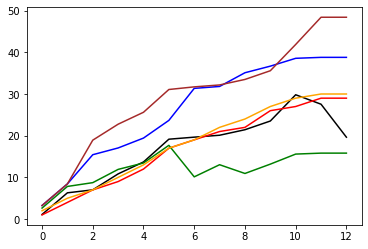

In [ ]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['y_buy'], color='blue')
plt.plot(df1['yb_buy'], color='red')
plt.plot(df1['yall_buy'], color='green')
plt.plot(df1['yallb_buy'], color='orange')
plt.plot(df1['yvote_buy'], color='brown')

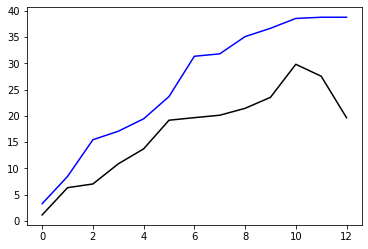

In [ ]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['y_buy'], color='blue')


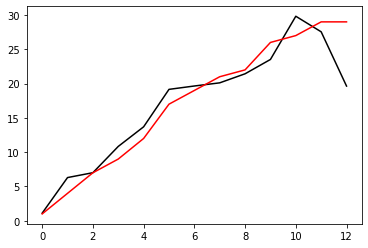

In [ ]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yb_buy'], color='red')

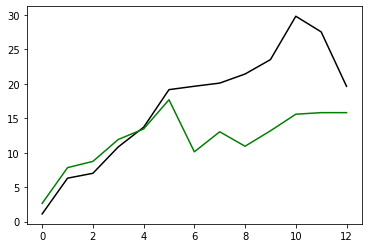

In [ ]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yall_buy'], color='green')

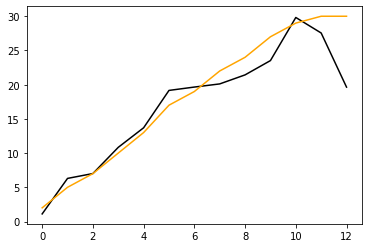

In [ ]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yallb_buy'], color='orange')

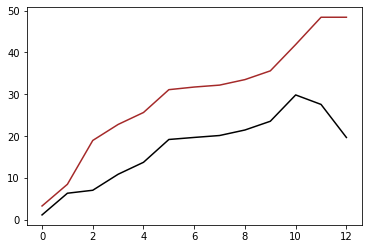

In [ ]:
plt.plot(df1['y_actual'], color='black')
plt.plot(df1['yvote_buy'], color='brown')

In [ ]:
#results.to_csv('/content/drive/MyDrive/Colab Notebooks/results_sky_hibs_20160101-20210803_.csv')
#performance.to_csv('/content/drive/MyDrive/Colab Notebooks/performance_sky_hibs_20190101-20210803_.csv')